In [2]:
import warnings
import pickle
import sys
import numpy as np
import time

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import dataloader_paths, dataloader_geo
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
import prediction_model_evaluation_metrics as metrics

In [3]:
# Load a network from pickle
datasize = 'full'
location = 'tromso'
model_date = '202204'
train_dates = ['202204', '202205', '202207']
test_dates = ['202206']
DP_tol = 10
min_samples = 13

network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [4]:
network.gdf[['lon', 'lat', 'sog', 'cog', 'nav_status', 'message_nr']].head(10)

,lon,lat,sog,cog,nav_status,message_nr
date_time_utc,,,,,,
2022-04-01 04:02:37,18.9728,69.6592,0.7,45.7,5,3
2022-04-01 04:05:06,18.9758,69.6590,3.1,113.0,5,3
2022-04-01 04:05:17,18.9762,69.6589,3.4,112.3,5,3
2022-04-01 04:05:27,18.9767,69.6588,3.6,111.5,5,3
2022-04-01 04:05:38,18.9773,69.6588,3.9,111.8,5,3
2022-04-01 04:05:48,18.9778,69.6587,4.1,111.3,5,3
2022-04-01 04:05:57,18.9782,69.6586,4.3,111.0,5,3
2022-04-01 04:06:06,18.9787,69.6586,4.4,111.9,5,1
2022-04-01 04:06:17,18.9793,69.6585,4.4,112.5,5,1


In [3]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, data_version='')

36924
36924 training paths loaded.


In [4]:
# Train MOGen Model
model = MOGenPathPrediction()
print(f'Training MOGen Model on {len(training_paths)} paths...')
model.train(training_paths, max_order=3, model_selection=True, training_mode='partial')

Training MOGen Model on 36924 paths...


order:  3; log_L (8 prcs): 100%|██████████████████| 8/8 [00:02<00:00,  2.86it/s]


Selected optimal maximum order K=2 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 1  |   1495     478942   | -290935.99  4364  590599.98
 2  |   6738     478942   | -216727.78 24967  483389.55
 3  |   19039    478942   | -178604.14 181395 719998.28


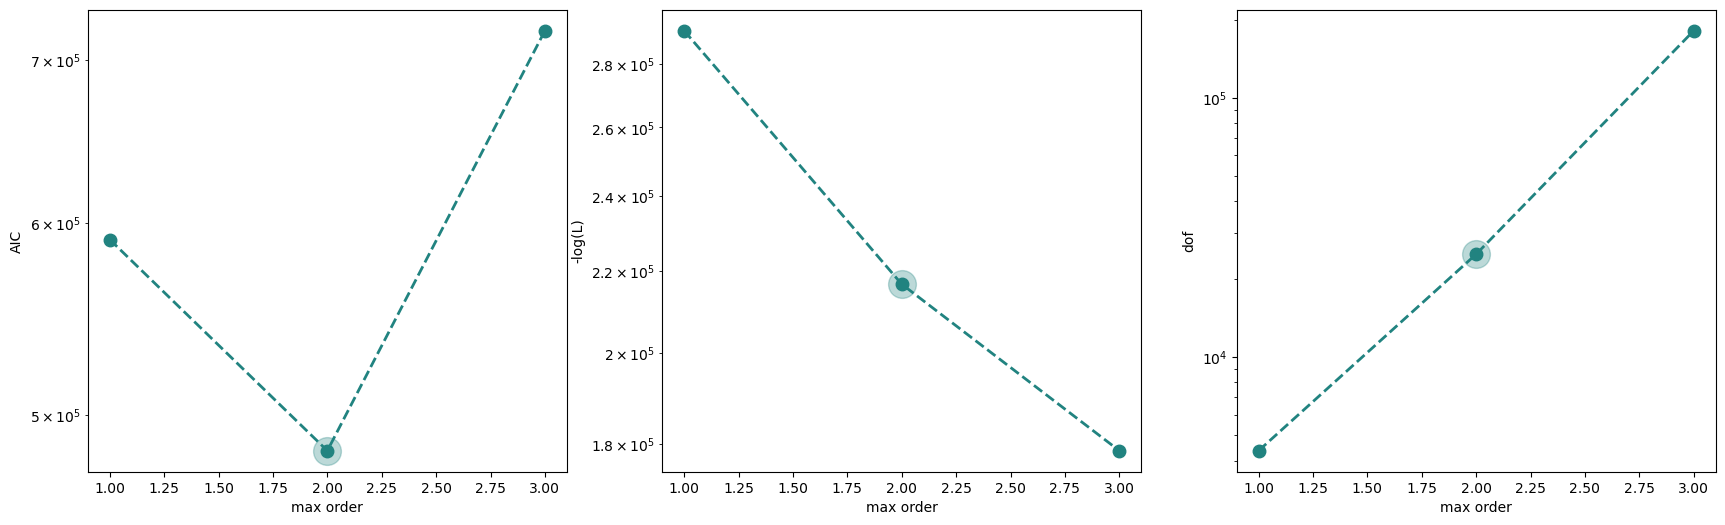

In [5]:
model.model.plot()

In [6]:
# Load test data from file
traj_path_prefix = '../../data/processed/'
all_test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                      0, -1, 1, data_version='')
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

12250
12250 test paths loaded.


In [7]:
##### Prediction parameters ######
prediction_task = 'next_nodes'  # 'next_nodes' or 'path'
n_walks = 1000
n_start_nodes = 1
n_steps = 10        # only needed for next nodes prediction
n_predictions = 1

# select test data
selection_start = 0
selection_end = -1
selection_step = 80

if prediction_task == 'next_nodes':
    # split test paths in subpaths
    sub_paths = dataloader_paths.split_path_data(all_test_paths, n_steps+n_start_nodes)
    if selection_end == -1:
        selection_end = len(sub_paths)
    selection = np.arange(selection_start, selection_end, selection_step)
    test_paths = sub_paths.iloc[selection]
else:
    if selection_end == -1:
        selection_end = len(all_test_paths)
    selection = np.arange(selection_start, selection_end, selection_step)
    test_paths = all_test_paths.iloc[selection]

In [8]:
# make predictions
start_time = time.time()

predictions = model.predict(prediction_task, test_paths, network.G, 
                            n_start_nodes=n_start_nodes, n_steps=n_steps, 
                            n_predictions=n_predictions, n_walks=n_walks)

end_time = time.time()  # end timer
print(f'Time elapsed: {(end_time-start_time)/60:.2f} minutes')
pps = len(test_paths)/(end_time-start_time)
print('Predictions per second: ', pps)

Making predictions for 843 samples with MOGen of order 2
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
Time elapsed: 34.92 minutes
Predictions per second:  0.4023667299092044


Evaluating 841 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.26 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 1436.42m
Median SSPD: 94.97m
Mean choice_accuracy: 0.5491


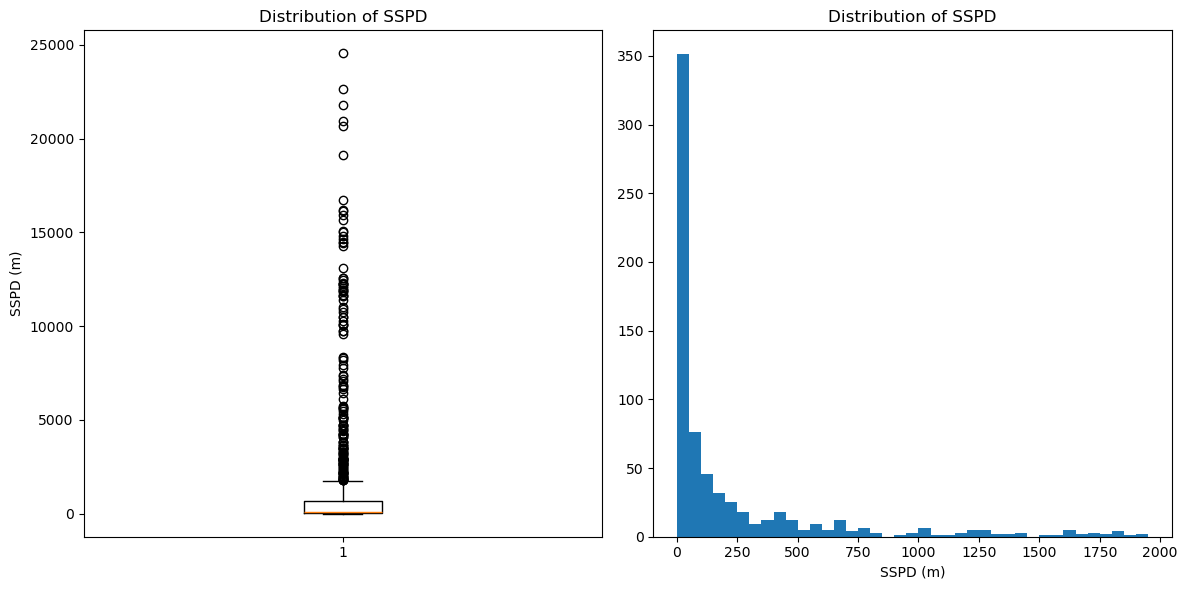

In [9]:
# evaluate
eval_mode = 'path'
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, eval_mode=eval_mode)

In [10]:
evaluation_results

,mmsi,true_path,predicted_path,distances,SSPD,choice_accuracy
0,205703000_0_2022-06-11 03:50:14,"(149, 707, 706, 689, 688, 693, 50, 647, 648, 6...","(149, 30, 330, 519, 515, 516, 124, 575, 596, 5...","[0.0, 184.47978927707956, 368.9595785541591, 5...",10933.622252,0.0
0,210149000_0_2022-06-28 14:43:04,"(67, 217, 639, 56, 138, 699, 836, 835, 837, 83...","(67, 217, 639, 56, 638, 138, 137, 713, 748, 74...","[0.0, 6.865915664632335e-12, 1.373183132926467...",1620.837015,0.3
0,210350000_1_2022-06-18 15:52:05,"(639, 56, 713, 748, 747, 682, 660, 611, 614, 6...","(639, 56, 138, 699, 137, 662, 713, 748, 747, 6...","[0.0, 1.5930991924987263e-10, 21.6017396095293...",805.464453,0.5
0,210350000_2_2022-06-23 18:25:09,"(854, 855, 821, 822, 817, 810, 811, 749, 833, ...","(854, 855, 821, 822, 817, 810, 811, 833, 834, ...","[0.0, 2.282509872796819e-11, 4.565019745593638...",19.293127,0.8
0,211219630_0_2022-06-02 03:48:38,"(693, 50, 647, 648, 67, 639, 56, 737, 770, 832...","(693, 50, 647, 648, 67, 217, 639, 56, 638, 138...","[0.0, 2.964440729754197e-11, 5.928881459508394...",692.238503,0.5
...,...,...,...,...,...,...
0,375219000_18_2022-06-19 03:40:39,"(199, 197, 194, 192, 193, 34, 30, 605, 637, 12...","(199, 197, 194, 192, 193, 34, 527, 526, 530, 6...","[0.0, 1.5012225237160528e-10, 2.80629838077765...",5169.195410,0.5
0,375219000_22_2022-06-20 00:51:13,"(851, 758, 801, 654, 655, 594, 567, 577, 581, ...","(851, 758, 801, 802, 771, 785, 786, 602, 618, ...","[0.0, 1.1832872471754525e-11, 2.36657449435090...",12558.482610,0.2
0,375219000_7_2022-06-04 01:03:00,"(124, 574, 575, 596, 585, 63, 202, 765, 768, 7...","(124, 574, 575, 624, 596, 585, 63, 202, 765, 7...","[0.0, 2.105526317896445e-11, 1.607460437180251...",25.444421,0.8
0,413494710_0_2022-06-28 05:11:22,"(560, 605, 604, 274, 476, 171, 66, 74, 484, 48...","(560, 605, 604, 633, 418, 181, 231, 225, 222, ...","[0.0, 4.055529301416393e-10, 2.232762085106630...",24543.270417,0.2


In [11]:
# plot predictions with the MOGen model
prediction_task = 'next_nodes'
example = test_paths.iloc[3]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

if prediction_task == 'next_nodes':
    predictions = model.predict_next_nodes(start_node=start_node, G=network.G, n_predictions=3, n_steps=3, n_walks=200)
if prediction_task == 'path':
    predictions, flag = model.predict_path(start_node, end_node, network.G, n_predictions=5, n_walks=2000, verbose=True)

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_MOGen_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_MOGen_predictions.html"}')

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


Map saved under ../../reports/maps/202204_waypoints_DP30_HDBSCAN25_stavanger_full_UTM_MOGen_predictions.html


In [12]:
from make_trajectories_from_AIS import add_ship_metadata

# add original mmsi column back to dataframe
evaluation_results.rename(columns={'mmsi':'id'}, inplace=True)
evaluation_results['mmsi'] = evaluation_results['id'].str[:9].astype(int)

# add metadata to each mmsi
meta_file = '../../data/external/seilas-2022.csv'
evaluation_results_meta = add_ship_metadata(meta_file, evaluation_results)

Geopandas has version 0.13.2
Movingpandas has version 0.17.1
Ship metadata has   4142 unique MMSIs
AIS raw data has    283 unique MMSIs
Overlap:            263 MMSIs


Ship metadata has   4142 unique MMSIs
AIS raw data has    283 unique MMSIs
Overlap:            263 MMSIs


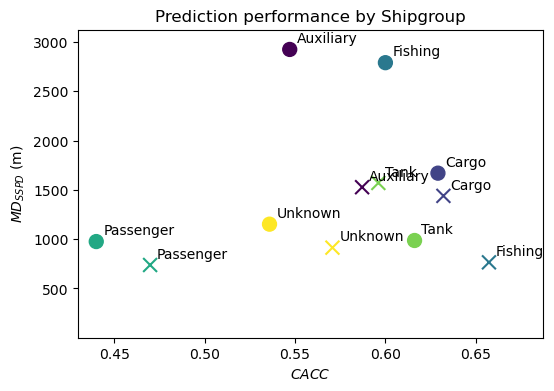

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
# add metadata to each mmsi
meta_file = '../../data/external/seilas-2022.csv'
evaluation_results_meta = add_ship_metadata(meta_file, evaluation_results)
evaluation_results_meta = evaluation_results_meta[evaluation_results_meta['skipsgruppe'] != 'Tug']

# get choice accuracy and SSPD by shipgroup
sspd_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['SSPD'].mean()
cacc_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['choice_accuracy'].mean()

x = cacc_by_group.values
y = sspd_by_group.values
categories = sspd_by_group.index

data = {
    'skipsgruppe': ['Auxiliary', 'Cargo', 'Fishing', 'Passenger', 'Tank', 'Unknown'],
    'value': [0.5871, 0.6321, 0.6573, 0.4698, 0.5961, 0.5707]
}
cacc_new = pd.DataFrame(data)
data = {
    'skipsgruppe': ['Auxiliary', 'Cargo', 'Fishing', 'Passenger', 'Tank', 'Unknown'],
    'value': [1527, 1439, 765, 738, 1570, 914]
}
sspd_new = pd.DataFrame(data)
x_new = cacc_new['value']
y_new = sspd_new['value']
categories_new = cacc_new['skipsgruppe']

fig, ax = plt.subplots(figsize=[6, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x, y, c=range(len(categories)), cmap='viridis', marker='o', s=100)
scatter = ax.scatter(x_new, y_new, c=range(len(categories_new)), cmap='viridis', marker='x', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')
    ax.annotate(category, (x_new[i], y_new[i]), textcoords="offset points", xytext=(5,5), ha='left')

max_x_value = max(max(x), max(x_new))
max_y_value = max(max(y), max(y_new))
min_x_value = min(min(x), min(x_new))
min_y_value = min(min(x), min(x_new))
ax.set_xlim(min_x_value-0.01, max_x_value+0.03)
ax.set_ylim(min_y_value, max_y_value+200)

ax.set_xlabel('$CACC$')
ax.set_ylabel('$MD_{SSPD}$ (m)')
plt.title('Prediction performance by Shipgroup')
plt.savefig('prediction_performance_by_ship_category_stavanger_MOGen.pdf')

plt.show()